# Vehicle Insurance Claim Fraud Detection
### The goal of this notebook is to:
1. Predict whether insurance claim fraud can be mitigated by training the algorithms (decision tree, random forest and logistic regression).
2. Calculate and compare the performance of the 3 algorithms.

## 1. Data Gathering

For vehicle insurance claim fraud, a dataset is chosen from [Kaggle](https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection) having 33 features and 15420 data entries. This dataset has several features that indicate the following:

| **Type** | **Features** |
|:---:|:---:|
| Vehicle | make, category, price, age |
| Customer | sex, age, marital-status, driver-rating, number-of-vehicles |
| Policy | policy-number, fault, type, deductible, days between events, police-report filed, witness present, agent-type, accident-area, address-change, base-policy, supplements |
| Data labeled with binary classification if claim was fraudulent or not (1 or 0) | fraud-found |


The data size available for this use-case is sufficient - more than 10 times degrees of freedom. The other observations ensure acceptable nulls/missing values (2%), the data is imbalanced 6%, however, it is in line with insurance industry trends.

In [1]:
from pyspark.sql import SparkSession

# Initializing Spark session
spark = SparkSession\
        .builder\
        .appName("Vehicle Insurance Claim Fraud Detection")\
        .config("spark.executor.memory", "5g") \
        .config("spark.driver.memory", "5g") \
        .getOrCreate()
print('Spark session is initialized.')

# Load the vehicle insurance claim fraud dataset from the csv file and create a dataframe
df = spark.read.format("csv").option("header", "true").load("../dataset/vehicle_insurance_claim_fraud_data.csv")
print('Spark dataframe is created from the dataset.')

Spark session is initialized.
Spark dataframe is created from the dataset.


## 2. Data Preparation

For data preparation, following steps were performed to improve the quality of the data:
1. Age: column has '0' as value for 2.07% rows.
2. To impute 'Age' column having 0 as value, a new column 'Imputed_Age' has been added to the dataframe which computes the average age from the 'AgeOfPolicyHolder' column ranged value.
3. All the numerical features are converted to double type to maintain uniformity.
4. The dataset is split into training and test set using random split (80/20 ratio).
5. One-hot encoding is performed for categorical features.
6. Features are extracted and training and test sets are assembled.

In [2]:
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

# Adds a new column to the dataframe called 'Imputed_Age' that copies the 'Age' column value when it is not 0, 
# or the average age from the range given in 'AgeOfPolicyHolder' column value
df = df.withColumn("Imputed_Age", when(col("Age") == 0, (split(col("AgeOfPolicyHolder"), " ")[0].cast("int") + 
    split(col("AgeOfPolicyHolder"), " ")[0].cast("int")) / 2).otherwise(col("Age")))

# Convert the columns having numerical values to Double type
numerical_cols = ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'Imputed_Age', 'FraudFound_P', 'RepNumber', 'Deductible', 
                  'DriverRating', 'Year']
for col in numerical_cols:
    df = df.withColumn(col, df[col].cast(DoubleType()))

# Divide the dataset into training and test sets
training, test = df.randomSplit([0.8, 0.2], seed=42)

# Create a list of the columns having categorical values
categorical_cols = ['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed', 'MonthClaimed', 'Sex', 'MaritalStatus', 
                    'Fault', 'PolicyType', 'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 
                    'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 
                    'AgentType', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'BasePolicy']

# Perform one-hot encoding for categorical features
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_indexed", outputCol=col+"_encoded") for col in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)
pipelineModel = pipeline.fit(training)
training_encoded = pipelineModel.transform(training).drop(*categorical_cols, *["PolicyNumber"])
test_encoded = pipelineModel.transform(test).drop(*categorical_cols, *["PolicyNumber"])

# Extracting the features and removing the 'FraudFound_P' column
features = training_encoded.columns
features.remove('FraudFound_P')

# Assembles the columns into a feature vector for the training and test sets
assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="keep")
train_df = assembler.transform(training_encoded).select("features", "FraudFound_P")
test_df = assembler.transform(test_encoded).select("features", "FraudFound_P")

# Count the number of records with FraudFound_P value as 0 and 1 in the training set
count_0 = train_df.filter(train_df["FraudFound_P"] == 0).count()
count_1 = train_df.filter(train_df["FraudFound_P"] == 1).count()

# Calculate the ratio of FraudFound_P values 0 and 1
fraud_ratio = count_1 / count_0

# Create separate DataFrames for minority and majority class
minority_df = train_df.filter(train_df["FraudFound_P"] == 1)
majority_df = train_df.filter(train_df["FraudFound_P"] == 0)

# Sample the majority class DataFrame to balance the dataset
balanced_majority_df = majority_df.sample(fraction=fraud_ratio, seed=42)

# Combine the minority class DataFrame and the balanced majority class DataFrame
balanced_train_df = minority_df.unionAll(balanced_majority_df)

# Shuffle the rows of the balanced DataFrame
balanced_train_df = balanced_train_df.orderBy(rand())

print('Data is prepared.')

Data is prepared.


## 3. Model Training

For this usecase, model understandability is a major aspect for competitive markets such as insurance. Hence, the model were chosen in a way that they are whitebox, simple to understand and able to generate workable insights for upselling in the business. Example: If the model shows that individuals who has a voluntary deductible of \$1000 don't commit fraud, customers willing to pay the same can be awarded with better insurance premiums. 

### 3.1 Decision Tree Classifier
Decision trees are the simplest and easiest to understand. To prevent overfitting, the model was adjusted by using techniques such as stratified sampling and balanced sampling. Fitting was performed on multiple hyperparameters settings: maxDepth, minInstancesPerNode

In [3]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder

# Define the decision tree classifier
dt = DecisionTreeClassifier(labelCol="FraudFound_P", featuresCol="features")

# Define the parameter grid for cross-validation
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Define the evaluator as precision for the classification
evaluator_dt = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="FraudFound_P",
                                              metricName="weightedPrecision")

print('Decision Tree Classifier, ParamGrid and Precision Evaluator is defined.')

Decision Tree Classifier, ParamGrid and Precision Evaluator is defined.


#### 3.1.1 Data Sampling
1. Simple Random Sampling
2. Stratified Sampling
3. Balanced Sampling

In [4]:
from pyspark.ml.tuning import CrossValidator
from stratifier import StratifiedCrossValidator

# Define the k-fold cross-validator
cv_dt = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5, seed=42)

# Define the stratified k-fold cross-validator
scv_dt = StratifiedCrossValidator(estimator=dt, estimatorParamMaps=paramGrid_dt, evaluator=evaluator_dt, numFolds=5)

# Run the Decision Tree model on the training set
random_model_dt = cv_dt.fit(train_df)

# Run the Decision Tree model using stratified k-fold cross-validation on the training set
stratified_model_dt = scv_dt.fit(train_df)

# Run the Decision Tree model on the balanced training set
balanced_model_dt = cv_dt.fit(balanced_train_df)

print('Models are trained.')

Models are trained.


#### 3.1.2 Decision Tree Model Comparison

Following comparison metrics were used for model evaluation:
1. Precision (since it’s more important to predict fraudsters)
2. Recall
3. F1 Score
4. Accuracy

In [14]:
# Get the predictions on the test set from Random Sampling
predictions_random_model = random_model_dt.transform(test_df)

# Get the predictions on the test set from Stratified Sampling
predictions_stratified_model = stratified_model_dt.transform(test_df)

# Get the predictions on the test set from Balanced Sampling
predictions_balanced_model = balanced_model_dt.transform(test_df)

# Set the evaluator metric to Precision
evaluator_dt.setMetricName('weightedPrecision')

# Precision for the decision tree model on Random Sampling
precision_random_model = evaluator_dt.evaluate(predictions_random_model)

# Precision for the decision tree model on Stratified Sampling
precision_stratified_model = evaluator_dt.evaluate(predictions_stratified_model)

# Precision for the decision tree model on Balanced Sampling
precision_balanced_model = evaluator_dt.evaluate(predictions_balanced_model)

# Set the evaluator metric to Recall
evaluator_dt.setMetricName('weightedRecall')

# Recall for the decision tree model on Random Sampling
recall_random_model = evaluator_dt.evaluate(predictions_random_model)

# Recall for the decision tree model on Stratified Sampling
recall_stratified_model = evaluator_dt.evaluate(predictions_stratified_model)

# Recall for the decision tree model on Balanced Sampling
recall_balanced_model = evaluator_dt.evaluate(predictions_balanced_model)

# Set the evaluator metric to F1
evaluator_dt.setMetricName('f1')

# F1 Score for the decision tree model on Random Sampling
f1_score_random_model = evaluator_dt.evaluate(predictions_random_model)

# F1 Score for the decision tree model on Stratified Sampling
f1_score_stratified_model = evaluator_dt.evaluate(predictions_stratified_model)

# F1 Score for the decision tree model on Balanced Sampling
f1_score_balanced_model = evaluator_dt.evaluate(predictions_balanced_model)

# Set the evaluator metric to Accuracy
evaluator_dt.setMetricName('accuracy')

# Accuracy for the decision tree model on Random Sampling
accuracy_random_model = evaluator_dt.evaluate(predictions_random_model)

# Accuracy for the decision tree model on Stratified Sampling
accuracy_stratified_model = evaluator_dt.evaluate(predictions_stratified_model)

# Accuracy for the decision tree model on Balanced Sampling
accuracy_balanced_model = evaluator_dt.evaluate(predictions_balanced_model)

print('Metrics are evaluated.')

Metrics are evaluated.


In [15]:
from IPython.display import Markdown, display

table = "| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |\n" + \
                 "|:---:|:---:|:---:|:---:|:---:|\n" + \
                 "| Random | {:.2f} | {:.2f} | {:.2f} | {:.2f} |\n" + \
                 "| Stratified | {:.2f} | {:.2f} | {:.2f} | {:.2f} |\n" + \
                 "| Balanced | {:.2f} | {:.2f} | {:.2f} | {:.2f} |"
print('Evaluation Metrics for fraud not found:')
display(Markdown(table.format(precision_random_model, recall_random_model, 
                 f1_score_random_model, accuracy_random_model, precision_stratified_model, recall_stratified_model,
                 f1_score_stratified_model, accuracy_stratified_model, precision_balanced_model, recall_balanced_model,
                 f1_score_balanced_model, accuracy_balanced_model)))

print('Evaluation Metrics for fraud found:')
display(Markdown(table.format(1-precision_random_model, 1-recall_random_model, 
                 1-f1_score_random_model, 1-accuracy_random_model, 1-precision_stratified_model, 1-recall_stratified_model,
                 1-f1_score_stratified_model, 1-accuracy_stratified_model, 1-precision_balanced_model, 1-recall_balanced_model,
                 1-f1_score_balanced_model, 1-accuracy_balanced_model)))

Evaluation Metrics for fraud not found:


| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |
|:---:|:---:|:---:|:---:|:---:|
| Random | 0.95 | 0.95 | 0.92 | 0.95 |
| Stratified | 0.95 | 0.95 | 0.92 | 0.95 |
| Balanced | 0.94 | 0.58 | 0.68 | 0.58 |

Evaluation Metrics for fraud found:


| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |
|:---:|:---:|:---:|:---:|:---:|
| Random | 0.05 | 0.05 | 0.08 | 0.05 |
| Stratified | 0.05 | 0.05 | 0.08 | 0.05 |
| Balanced | 0.06 | 0.42 | 0.32 | 0.42 |

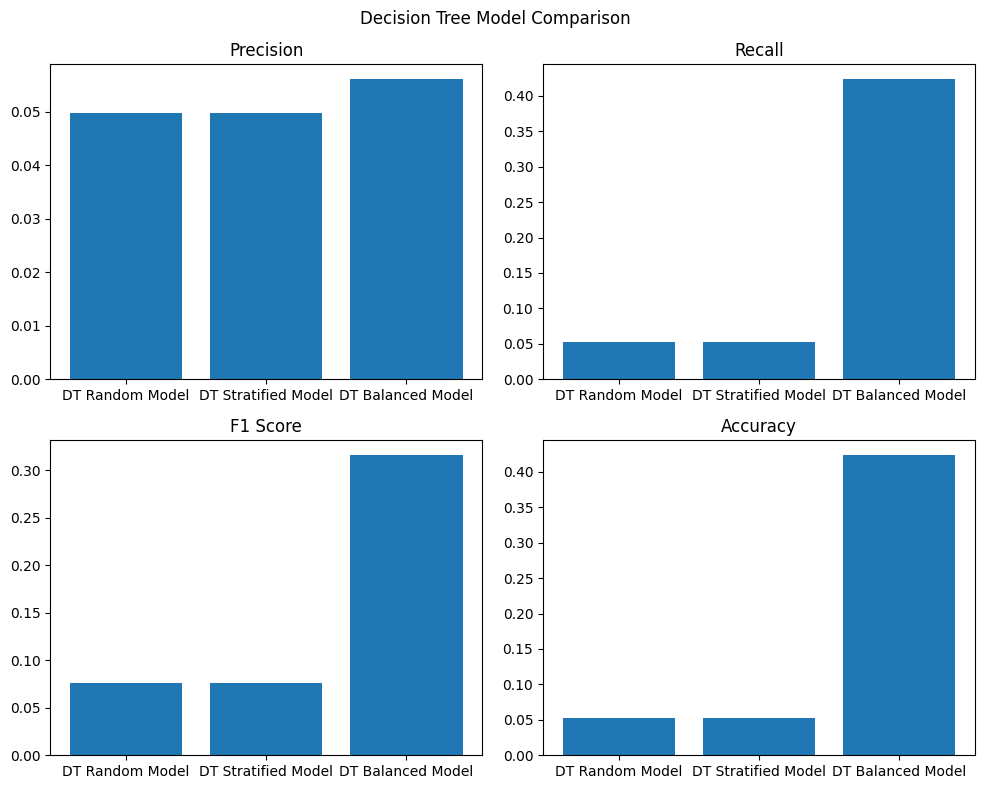

In [16]:
import matplotlib.pyplot as plt

# Create a list of labels for each model
dt_models = ['DT Random Model', 'DT Stratified Model', 'DT Balanced Model']

# Create a list of values for each metric for each model
precision_dt = [1-precision_random_model, 1-precision_stratified_model, 1-precision_balanced_model]
recall_dt = [1-recall_random_model, 1-recall_stratified_model, 1-recall_balanced_model]
f1_score_dt = [1-f1_score_random_model, 1-f1_score_stratified_model, 1-f1_score_balanced_model]
accuracy_dt = [1-accuracy_random_model, 1-accuracy_stratified_model, 1-accuracy_balanced_model]

# Create a bar plot with four subplots for each metric
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].bar(dt_models, precision_dt)
axs[0, 0].set_title('Precision')
axs[0, 1].bar(dt_models, recall_dt)
axs[0, 1].set_title('Recall')
axs[1, 0].bar(dt_models, f1_score_dt)
axs[1, 0].set_title('F1 Score')
axs[1, 1].bar(dt_models, accuracy_dt)
axs[1, 1].set_title('Accuracy')

# Add axis labels and a title
fig.suptitle('Decision Tree Model Comparison')
plt.tight_layout()
plt.show()

In [40]:
#Save the information from best models of the 3 decision tree models

bestModel_random_dt = random_model_dt.bestModel
bestModel_random_dt_depth = bestModel_random_dt.depth
bestModel_random_dt_numNodes = bestModel_random_dt.numNodes
bestModel_random_dt_numFeatures = bestModel_random_dt.numFeatures
bestModel_random_dt_importances = list(zip(features, bestModel_random_dt.featureImportances))

bestModel_stratified_dt = stratified_model_dt.bestModel
bestModel_stratified_dt_depth = bestModel_stratified_dt.depth
bestModel_stratified_dt_numNodes = bestModel_stratified_dt.numNodes
bestModel_stratified_dt_numFeatures = bestModel_stratified_dt.numFeatures
bestModel_stratified_dt_importances = list(zip(features, bestModel_stratified_dt.featureImportances))

bestModel_balanced_dt = balanced_model_dt.bestModel
bestModel_balanced_dt_depth = bestModel_balanced_dt.depth
bestModel_balanced_dt_numNodes = bestModel_balanced_dt.numNodes
bestModel_balanced_dt_numFeatures = bestModel_balanced_dt.numFeatures
bestModel_balanced_dt_importances = list(zip(features, bestModel_balanced_dt.featureImportances))

print('Information captured.')

Information captured.


In [41]:
import pickle

with open('dt_metrics.pkl', 'wb') as f:
    pickle.dump([bestModel_random_dt_depth, bestModel_random_dt_numNodes, bestModel_random_dt_numFeatures, 
                 bestModel_random_dt_importances, precision_random_model, recall_random_model, 
                 f1_score_random_model, accuracy_random_model, bestModel_stratified_dt_depth, bestModel_stratified_dt_numNodes,
                 bestModel_stratified_dt_numFeatures, bestModel_stratified_dt_importances,
                 precision_stratified_model, recall_stratified_model, f1_score_stratified_model, accuracy_stratified_model, 
                 bestModel_balanced_dt_depth, bestModel_balanced_dt_numNodes, bestModel_balanced_dt_numFeatures, 
                 bestModel_balanced_dt_importances, precision_balanced_model, recall_balanced_model,
                 f1_score_balanced_model, accuracy_balanced_model], f)
    
print('Information saved.')

Information saved.


### 3.2 Random Forest Classifier

Random forest model was adjusted by using techniques such as stratified sampling and balanced sampling. Fitting was performed on multiple hyperparameters settings: numTrees, maxDepth, minInfoGain, subsamplingRate

In [3]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder

# Define the random forest classifier
rf = RandomForestClassifier(labelCol="FraudFound_P", featuresCol="features")

# Define the parameter grid for cross-validation
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [2, 5]) \
    .addGrid(rf.maxDepth, [2, 5, 8]) \
    .addGrid(rf.minInfoGain, [0.0, 0.05]) \
    .addGrid(rf.subsamplingRate, [0.5, 0.7, 1.0]) \
    .build()

# Define the evaluator as precision for the classification
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="FraudFound_P", 
                      metricName="weightedPrecision")

print('Random Forest Classifier, ParamGrid and Precision Evaluator is defined.')

Random Forest Classifier, ParamGrid and Precision Evaluator is defined.


#### 3.2.1 Data Sampling
1. Simple Random Sampling
2. Stratified Sampling
3. Balanced Sampling

In [5]:
from pyspark.ml.tuning import CrossValidator
from stratifier import StratifiedCrossValidator

# Define the k-fold cross-validator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_rf, numFolds=5)

# Define the stratified k-fold cross-validator
scv_rf = StratifiedCrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_rf, numFolds=5)

# Run the Random Forest model on the training set
random_model_rf = cv_rf.fit(train_df)

# Run the Random Forest model on the balanced training set
balanced_model_rf = cv_rf.fit(balanced_train_df)

In [6]:
# Run the Random Forest model using stratified k-fold cross-validation on the training set
stratified_model_rf = scv_rf.fit(train_df)

print('Models are trained.')

Models are trained.


#### 3.2.2 Random Forest Model Comparison

Following comparison metrics were used for model evaluation:
1. Precision
2. Recall
3. F1 Score
4. Accuracy

In [7]:
# Get the predictions on the test set from Random Sampling
predictions_random_model_rf = random_model_rf.transform(test_df)

# Get the predictions on the test set from Stratified Sampling
predictions_stratified_model_rf = stratified_model_rf.transform(test_df)

# Get the predictions on the test set from Balanced Sampling
predictions_balanced_model_rf = balanced_model_rf.transform(test_df)

# Set the evaluator metric to Precision
evaluator_rf.setMetricName('weightedPrecision')

# Precision for the decision tree model on Random Sampling
precision_random_model_rf = evaluator_rf.evaluate(predictions_random_model_rf)

# Precision for the decision tree model on Stratified Sampling
precision_stratified_model_rf = evaluator_rf.evaluate(predictions_stratified_model_rf)

# Precision for the decision tree model on Balanced Sampling
precision_balanced_model_rf = evaluator_rf.evaluate(predictions_balanced_model_rf)

# Set the evaluator metric to Recall
evaluator_rf.setMetricName('weightedRecall')

# Recall for the decision tree model on Random Sampling
recall_random_model_rf = evaluator_rf.evaluate(predictions_random_model_rf)

# Recall for the decision tree model on Stratified Sampling
recall_stratified_model_rf = evaluator_rf.evaluate(predictions_stratified_model_rf)

# Recall for the decision tree model on Balanced Sampling
recall_balanced_model_rf = evaluator_rf.evaluate(predictions_balanced_model_rf)

# Set the evaluator metric to F1
evaluator_rf.setMetricName('f1')

# F1 Score for the decision tree model on Random Sampling
f1_score_random_model_rf = evaluator_rf.evaluate(predictions_random_model_rf)

# F1 Score for the decision tree model on Stratified Sampling
f1_score_stratified_model_rf = evaluator_rf.evaluate(predictions_stratified_model_rf)

# F1 Score for the decision tree model on Balanced Sampling
f1_score_balanced_model_rf = evaluator_rf.evaluate(predictions_balanced_model_rf)

# Set the evaluator metric to Accuracy
evaluator_rf.setMetricName('accuracy')

# Accuracy for the decision tree model on Random Sampling
accuracy_random_model_rf = evaluator_rf.evaluate(predictions_random_model_rf)

# Accuracy for the decision tree model on Stratified Sampling
accuracy_stratified_model_rf = evaluator_rf.evaluate(predictions_stratified_model_rf)

# Accuracy for the decision tree model on Balanced Sampling
accuracy_balanced_model_rf = evaluator_rf.evaluate(predictions_balanced_model_rf)

print('Metrics are evaluated.')

Metrics are evaluated.


In [8]:
from IPython.display import Markdown, display

table = "| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |\n" + \
                 "|:---:|:---:|:---:|:---:|:---:|\n" + \
                 "| Random | {:.2f} | {:.2f} | {:.2f} | {:.2f} |\n" + \
                 "| Stratified | {:.2f} | {:.2f} | {:.2f} | {:.2f} |\n" + \
                 "| Balanced | {:.2f} | {:.2f} | {:.2f} | {:.2f} |"
print('Evaluation Metrics for fraud not found:')
display(Markdown(table.format(precision_random_model_rf, recall_random_model_rf, 
                 f1_score_random_model_rf, accuracy_random_model_rf, precision_stratified_model_rf, recall_stratified_model_rf,
                 f1_score_stratified_model_rf, accuracy_stratified_model_rf, precision_balanced_model_rf, 
                 recall_balanced_model_rf, f1_score_balanced_model_rf, accuracy_balanced_model_rf)))

print('Evaluation Metrics for fraud found:')
display(Markdown(table.format(1-precision_random_model_rf, 1-recall_random_model_rf, 
                 1-f1_score_random_model_rf, 1-accuracy_random_model_rf, 1-precision_stratified_model_rf, 
                 1-recall_stratified_model_rf, 1-f1_score_stratified_model_rf, 1-accuracy_stratified_model_rf, 
                 1-precision_balanced_model_rf, 1-recall_balanced_model_rf, 1-f1_score_balanced_model_rf, 
                 1-accuracy_balanced_model_rf)))

Evaluation Metrics for fraud not found:


| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |
|:---:|:---:|:---:|:---:|:---:|
| Random | 0.94 | 0.95 | 0.92 | 0.95 |
| Stratified | 0.94 | 0.95 | 0.92 | 0.95 |
| Balanced | 0.94 | 0.59 | 0.70 | 0.59 |

Evaluation Metrics for fraud found:


| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |
|:---:|:---:|:---:|:---:|:---:|
| Random | 0.06 | 0.05 | 0.08 | 0.05 |
| Stratified | 0.06 | 0.05 | 0.08 | 0.05 |
| Balanced | 0.06 | 0.41 | 0.30 | 0.41 |

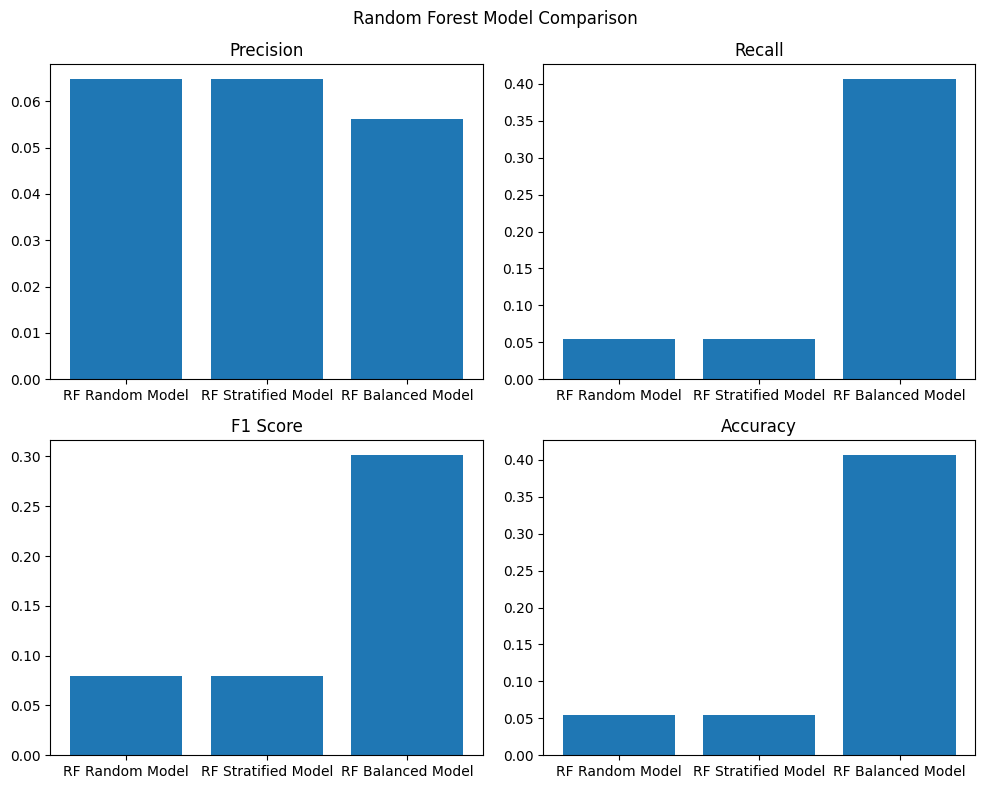

In [35]:
import matplotlib.pyplot as plt_rf

# Create a list of labels for each model
rf_models = ['RF Random Model', 'RF Stratified Model', 'RF Balanced Model']

# Create a list of values for each metric for each model
precision_rf = [1 - precision_random_model_rf, 1 - precision_stratified_model_rf, 1 - precision_balanced_model_rf]
recall_rf = [1 - recall_random_model_rf, 1 - recall_stratified_model_rf, 1 - recall_balanced_model_rf]
f1_score_rf = [1 - f1_score_random_model_rf, 1 - f1_score_stratified_model_rf, 1 - f1_score_balanced_model_rf]
accuracy_rf = [1 - accuracy_random_model_rf, 1 - accuracy_stratified_model_rf, 1 - accuracy_balanced_model_rf]

# Create a bar plot with four subplots for each metric
fig_rf, axs_rf = plt_rf.subplots(2, 2, figsize=(10, 8))
axs_rf[0, 0].bar(rf_models, precision_rf)
axs_rf[0, 0].set_title('Precision')
axs_rf[0, 1].bar(rf_models, recall_rf)
axs_rf[0, 1].set_title('Recall')
axs_rf[1, 0].bar(rf_models, f1_score_rf)
axs_rf[1, 0].set_title('F1 Score')
axs_rf[1, 1].bar(rf_models, accuracy_rf)
axs_rf[1, 1].set_title('Accuracy')

# Add axis labels and a title
fig_rf.suptitle('Random Forest Model Comparison')
plt_rf.tight_layout()
plt_rf.show()

In [32]:
#Save the information from best models of the 3 decision tree models

bestModel_random_rf = random_model_rf.bestModel
bestModel_random_rf_numFeatures = bestModel_random_rf.numFeatures
bestModel_random_rf_importances = list(zip(features, bestModel_random_rf.featureImportances))

bestModel_stratified_rf = stratified_model_rf.bestModel
bestModel_stratified_rf_numFeatures = bestModel_stratified_rf.numFeatures
bestModel_stratified_rf_importances = list(zip(features, bestModel_stratified_rf.featureImportances))

bestModel_balanced_rf = balanced_model_rf.bestModel
bestModel_balanced_rf_numFeatures = bestModel_balanced_rf.numFeatures
bestModel_balanced_rf_importances = list(zip(features, bestModel_balanced_rf.featureImportances))

print('Information captured.')

Information captured.


In [33]:
import pickle

with open('rf_metrics.pkl', 'wb') as f:
    pickle.dump([bestModel_random_rf_numFeatures, bestModel_random_rf_importances, precision_random_model_rf, 
                 recall_random_model_rf, f1_score_random_model_rf, accuracy_random_model_rf, 
                 bestModel_stratified_rf_numFeatures, bestModel_stratified_rf_importances, precision_stratified_model_rf, 
                 recall_stratified_model_rf, f1_score_stratified_model_rf, accuracy_stratified_model_rf, 
                 bestModel_balanced_rf_numFeatures, bestModel_balanced_rf_importances, precision_balanced_model_rf, 
                 recall_balanced_model_rf, f1_score_balanced_model_rf, accuracy_balanced_model_rf], f)
    
print('Information saved.')

Information saved.


### 3.3 Logistic Regression

Logistic Regression model is mainly used for binary classification. Here the model is adjusted by using techniques such as stratified sampling and balanced sampling. Fitting was performed on hyperparameters settings: elasticNetParam, regParam

In [3]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder

# Define the logistic regression model
lr = LogisticRegression(labelCol="FraudFound_P", featuresCol="features")

# Define the parameter grid for cross-validation
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.8]) \
    .addGrid(lr.regParam, [0.3]) \
    .build()

# Define the evaluator as precision for the classification
evaluator_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="FraudFound_P", 
                      metricName="weightedPrecision")

print('Logistic Regression Model, ParamGrid and Precision Evaluator is defined.')

Logistic Regression Model, ParamGrid and Precision Evaluator is defined.


#### 3.3.1 Data Sampling
1. Simple Random Sampling
2. Stratified Sampling
3. Balanced Sampling

In [4]:
from pyspark.ml.tuning import CrossValidator
from stratifier import StratifiedCrossValidator

# Define the k-fold cross-validator
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_lr, numFolds=5)

# Define the stratified k-fold cross-validator
scv_lr = StratifiedCrossValidator(estimator=lr, estimatorParamMaps=paramGrid_lr, evaluator=evaluator_lr, numFolds=5)

# Run the Logistic Regression model on the training set
random_model_lr = cv_lr.fit(train_df)

# Run the Logistic Regression model using stratified k-fold cross-validation on the training set
stratified_model_lr = scv_lr.fit(train_df)

# Run the Logistic Regression model on the balanced training set
balanced_model_lr = cv_lr.fit(balanced_train_df)

print('Models are trained.')

Models are trained.


#### 3.3.2 Logistic Regression Model Comparison

Following comparison metrics were used for model evaluation:
1. Precision
2. Recall
3. F1 Score
4. Accuracy

In [5]:
# Get the predictions on the test set from Random Sampling
predictions_random_model_lr = random_model_lr.transform(test_df)

# Get the predictions on the test set from Stratified Sampling
predictions_stratified_model_lr = stratified_model_lr.transform(test_df)

# Get the predictions on the test set from Balanced Sampling
predictions_balanced_model_lr = balanced_model_lr.transform(test_df)

# Set the evaluator metric to Precision
evaluator_lr.setMetricName('weightedPrecision')

# Precision for the decision tree model on Random Sampling
precision_random_model_lr = evaluator_lr.evaluate(predictions_random_model_lr)

# Precision for the decision tree model on Stratified Sampling
precision_stratified_model_lr = evaluator_lr.evaluate(predictions_stratified_model_lr)

# Precision for the decision tree model on Balanced Sampling
precision_balanced_model_lr = evaluator_lr.evaluate(predictions_balanced_model_lr)

# Set the evaluator metric to Recall
evaluator_lr.setMetricName('weightedRecall')

# Recall for the decision tree model on Random Sampling
recall_random_model_lr = evaluator_lr.evaluate(predictions_random_model_lr)

# Recall for the decision tree model on Stratified Sampling
recall_stratified_model_lr = evaluator_lr.evaluate(predictions_stratified_model_lr)

# Recall for the decision tree model on Balanced Sampling
recall_balanced_model_lr = evaluator_lr.evaluate(predictions_balanced_model_lr)

# Set the evaluator metric to F1
evaluator_lr.setMetricName('f1')

# F1 Score for the decision tree model on Random Sampling
f1_score_random_model_lr = evaluator_lr.evaluate(predictions_random_model_lr)

# F1 Score for the decision tree model on Stratified Sampling
f1_score_stratified_model_lr = evaluator_lr.evaluate(predictions_stratified_model_lr)

# F1 Score for the decision tree model on Balanced Sampling
f1_score_balanced_model_lr = evaluator_lr.evaluate(predictions_balanced_model_lr)

# Set the evaluator metric to Accuracy
evaluator_lr.setMetricName('accuracy')

# Accuracy for the decision tree model on Random Sampling
accuracy_random_model_lr = evaluator_lr.evaluate(predictions_random_model_lr)

# Accuracy for the decision tree model on Stratified Sampling
accuracy_stratified_model_lr = evaluator_lr.evaluate(predictions_stratified_model_lr)

# Accuracy for the decision tree model on Balanced Sampling
accuracy_balanced_model_lr = evaluator_lr.evaluate(predictions_balanced_model_lr)

print('Metrics are evaluated.')

Metrics are evaluated.


In [6]:
from IPython.display import Markdown, display

table = "| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |\n" + \
                 "|:---:|:---:|:---:|:---:|:---:|\n" + \
                 "| Random | {:.2f} | {:.2f} | {:.2f} | {:.2f} |\n" + \
                 "| Stratified | {:.2f} | {:.2f} | {:.2f} | {:.2f} |\n" + \
                 "| Balanced | {:.2f} | {:.2f} | {:.2f} | {:.2f} |"
print('Evaluation Metrics for fraud not found:')
display(Markdown(table.format(precision_random_model_lr, recall_random_model_lr, 
                 f1_score_random_model_lr, accuracy_random_model_lr, precision_stratified_model_lr, recall_stratified_model_lr,
                 f1_score_stratified_model_lr, accuracy_stratified_model_lr, precision_balanced_model_lr, recall_balanced_model_lr,
                 f1_score_balanced_model_lr, accuracy_balanced_model_lr)))

print('Evaluation Metrics for fraud found:')
display(Markdown(table.format(1-precision_random_model_lr, 1-recall_random_model_lr, 
                 1-f1_score_random_model_lr, 1-accuracy_random_model_lr, 1-precision_stratified_model_lr, 1-recall_stratified_model_lr,
                 1-f1_score_stratified_model_lr, 1-accuracy_stratified_model_lr, 1-precision_balanced_model_lr, 1-recall_balanced_model_lr,
                 1-f1_score_balanced_model_lr, 1-accuracy_balanced_model_lr)))

Evaluation Metrics for fraud not found:


| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |
|:---:|:---:|:---:|:---:|:---:|
| Random | 0.89 | 0.95 | 0.92 | 0.95 |
| Stratified | 0.89 | 0.95 | 0.92 | 0.95 |
| Balanced | 0.89 | 0.95 | 0.92 | 0.95 |

Evaluation Metrics for fraud found:


| **Type of sampling** | **Precision** | **Recall** | **F1 Score** | **Accuracy** |
|:---:|:---:|:---:|:---:|:---:|
| Random | 0.11 | 0.05 | 0.08 | 0.05 |
| Stratified | 0.11 | 0.05 | 0.08 | 0.05 |
| Balanced | 0.11 | 0.05 | 0.08 | 0.05 |

Even after applying 3 models for logistic regression algorithm on different type of samplings, the results of logistic regression remain the same.

In [20]:
#Save the information from best models of the 3 logistic regression models

from pyspark.ml.stat import Correlation

bestModel_random_lr = random_model_lr.bestModel
coefficients_random_lr = bestModel_random_lr.coefficients
intercepts_random_lr = bestModel_random_lr.interceptVector
bestModel_stratified_lr = stratified_model_lr.bestModel
coefficients_stratified_lr = bestModel_stratified_lr.coefficients
intercepts_stratified_lr = bestModel_stratified_lr.interceptVector
bestModel_balanced_lr = balanced_model_lr.bestModel
intercepts_balanced_lr = bestModel_balanced_lr.interceptVector

print('Information captured.')

Information captured.


In [21]:
import pickle

with open('lr_metrics.pkl', 'wb') as f:
    pickle.dump([coefficients_random_lr, intercepts_random_lr, precision_random_model_lr, recall_random_model_lr, 
                 f1_score_random_model_lr, accuracy_random_model_lr, coefficients_stratified_lr, intercepts_stratified_lr,
                 precision_stratified_model_lr, recall_stratified_model_lr, f1_score_stratified_model_lr, 
                 accuracy_stratified_model_lr, coefficients_balanced_lr, intercepts_balanced_lr, precision_balanced_model_lr, 
                 recall_balanced_model_lr, f1_score_balanced_model_lr, accuracy_balanced_model_lr], f)
    
print('Information saved.')

Information saved.


### 4. Feature comparisons for all the models and visualizations

In [37]:
import pickle

# Open the pickled file in read-binary mode
with open('dt_metrics.pkl', 'rb') as f:
    # Load the pickled object
    dt_metrics = pickle.load(f)

In [38]:
import pickle

# Open the pickled file in read-binary mode
with open('rf_metrics.pkl', 'rb') as f:
    # Load the pickled object
    rf_metrics = pickle.load(f)

In [39]:
import pickle

# Open the pickled file in read-binary mode
with open('lr_metrics.pkl', 'rb') as f:
    # Load the pickled object
    lr_metrics = pickle.load(f)

In [43]:
# Feature importances from all the models

import pandas as pd
import numpy as np

bestModel_random_dt_importances = pd.DataFrame(dt_metrics[3])
bestModel_random_dt_importances.columns = ['Features', 'Random DT']
bestModel_stratified_dt_importances = pd.DataFrame(dt_metrics[11])
bestModel_stratified_dt_importances.columns = ['Features', 'Stratified DT']
bestModel_balanced_dt_importances = pd.DataFrame(dt_metrics[19])
bestModel_balanced_dt_importances.columns = ['Features', 'Balanced DT']

bestModel_random_rf_importances = pd.DataFrame(rf_metrics[1])
bestModel_random_rf_importances.columns = ['Features', 'Random RF']
bestModel_stratified_rf_importances = pd.DataFrame(rf_metrics[7])
bestModel_stratified_rf_importances.columns = ['Features', 'Stratified RF']
bestModel_balanced_rf_importances = pd.DataFrame(rf_metrics[13])
bestModel_balanced_rf_importances.columns = ['Features', 'Balanced RF']

featureImportance = pd.merge(bestModel_random_dt_importances, bestModel_stratified_dt_importances, on = 'Features', how = 'outer')
featureImportance = pd.merge(featureImportance, bestModel_balanced_dt_importances, on = 'Features', how = 'outer')
featureImportance = pd.merge(featureImportance, bestModel_random_rf_importances, on = 'Features', how = 'outer')
featureImportance = pd.merge(featureImportance, bestModel_stratified_rf_importances, on = 'Features', how = 'outer')
featureImportance = pd.merge(featureImportance, bestModel_balanced_rf_importances, on = 'Features', how = 'outer')
featureImportance = featureImportance.round(3)
featureImportance['maxImportance'] = featureImportance[featureImportance.select_dtypes(include=np.number).columns].max(axis=1)
featureImportance.sort_values('maxImportance', ascending=False)

,Features,Random DT,Stratified DT,Balanced DT,Random RF,Stratified RF,Balanced RF,maxImportance
31,BasePolicy_indexed,0.250,0.250,0.56,0.004,0.004,0.003,0.560
16,Fault_indexed,0.354,0.354,0.44,0.051,0.051,0.083,0.440
17,PolicyType_indexed,0.000,0.000,0.00,0.044,0.044,0.242,0.242
29,AddressChange_Claim_indexed,0.220,0.220,0.00,0.031,0.031,0.024,0.220
24,AgeOfPolicyHolder_indexed,0.176,0.176,0.00,0.017,0.017,0.003,0.176
13,MonthClaimed_indexed,0.000,0.000,0.00,0.054,0.054,0.016,0.054
3,RepNumber,0.000,0.000,0.00,0.037,0.037,0.004,0.037
8,Month_indexed,0.000,0.000,0.00,0.034,0.034,0.018,0.034
10,Make_indexed,0.000,0.000,0.00,0.028,0.028,0.029,0.029
7,Imputed_Age,0.000,0.000,0.00,0.025,0.025,0.009,0.025


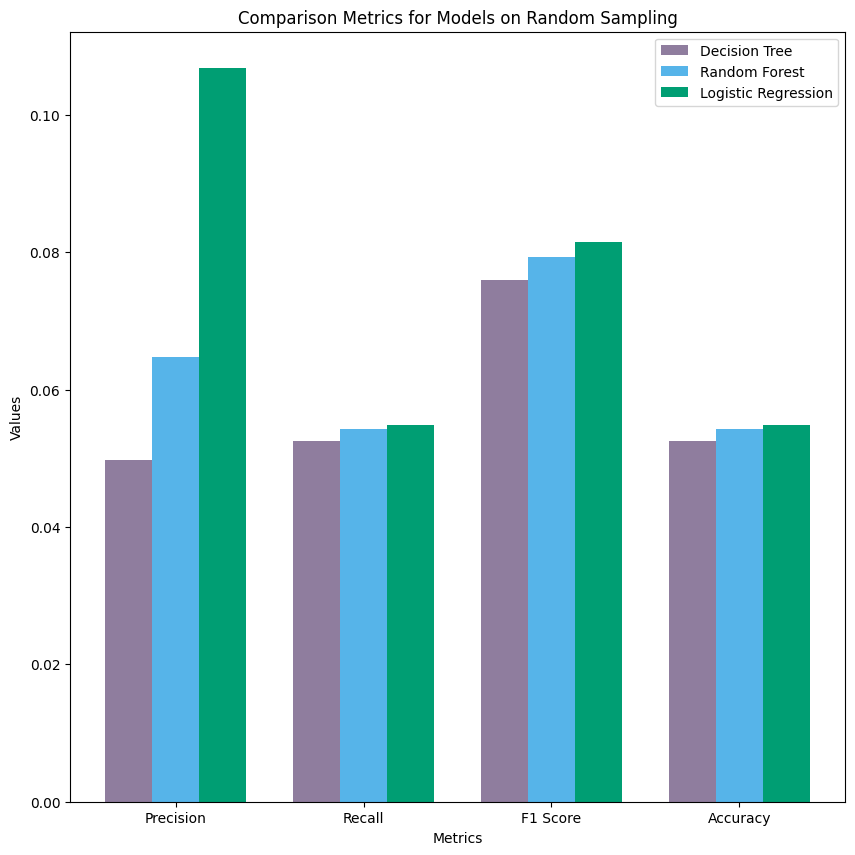

In [48]:
# Comparison Metrics for Models on Random Sampling

import numpy as np
import matplotlib.pyplot as plt_1

N = 4
ind = np.arange(N)
width = 0.25

dt_random = [1-dt_metrics[4], 1-dt_metrics[5], 1-dt_metrics[6], 1-dt_metrics[7]]
rf_random = [1-rf_metrics[2], 1-rf_metrics[3], 1-rf_metrics[4], 1-rf_metrics[5]]
lr_random = [1-lr_metrics[2], 1-lr_metrics[3], 1-lr_metrics[4], 1-lr_metrics[5]]

bar1 = plt_1.bar(ind, dt_random, width, color = '#8F7D9E')
bar2 = plt_1.bar(ind+width, rf_random, width, color='#56B4E9')
bar3 = plt_1.bar(ind+width*2, lr_random, width, color = '#009E73')

plt_1.xlabel("Metrics")
plt_1.ylabel('Values')
plt_1.title("Comparison Metrics for Models on Random Sampling")

plt_1.xticks(ind+width,['Precision', 'Recall', 'F1 Score', 'Accuracy'])
plt_1.legend( (bar1, bar2, bar3), ('Decision Tree', 'Random Forest', 'Logistic Regression') )
plt_1.grid(False)
plt_1.show()

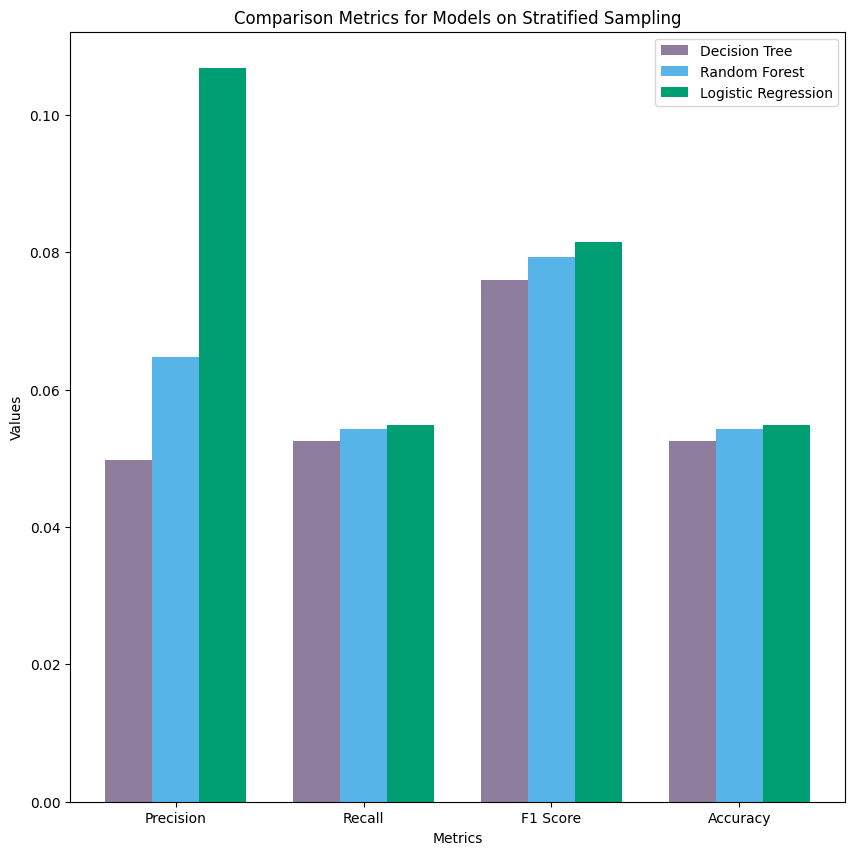

In [49]:
# Comparison Metrics for Models on Stratified Sampling

import numpy as np
import matplotlib.pyplot as plt_1

N = 4
ind = np.arange(N)
width = 0.25

dt_stratified = [1-dt_metrics[12], 1-dt_metrics[13], 1-dt_metrics[14], 1-dt_metrics[15]]
rf_stratified = [1-rf_metrics[8], 1-rf_metrics[9], 1-rf_metrics[10], 1-rf_metrics[11]]
lr_stratified = [1-lr_metrics[8], 1-lr_metrics[9], 1-lr_metrics[10], 1-lr_metrics[11]]

bar1 = plt_1.bar(ind, dt_stratified, width, color = '#8F7D9E')
bar2 = plt_1.bar(ind+width, rf_stratified, width, color='#56B4E9')
bar3 = plt_1.bar(ind+width*2, lr_stratified, width, color = '#009E73')

plt_1.xlabel("Metrics")
plt_1.ylabel('Values')
plt_1.title("Comparison Metrics for Models on Stratified Sampling")

plt_1.xticks(ind+width,['Precision', 'Recall', 'F1 Score', 'Accuracy'])
plt_1.legend( (bar1, bar2, bar3), ('Decision Tree', 'Random Forest', 'Logistic Regression') )
plt_1.grid(False)
plt_1.show()

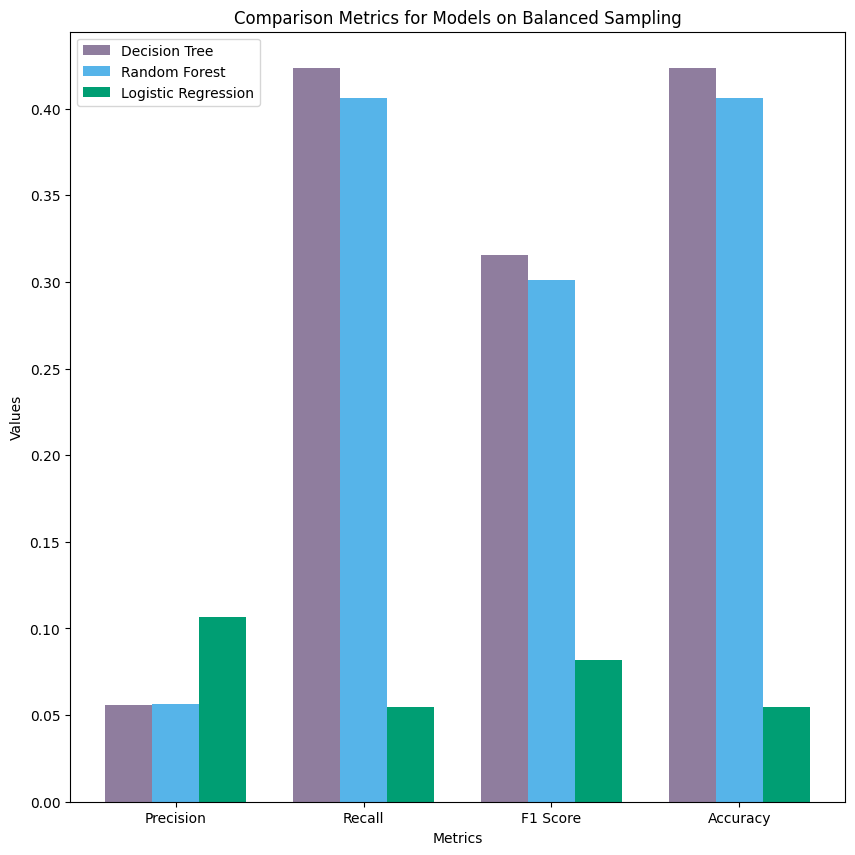

In [50]:
# Comparison Metrics for Models on Balanced Sampling

import numpy as np
import matplotlib.pyplot as plt_1

N = 4
ind = np.arange(N)
width = 0.25

dt_balanced = [1-dt_metrics[20], 1-dt_metrics[21], 1-dt_metrics[22], 1-dt_metrics[23]]
rf_balanced = [1-rf_metrics[14], 1-rf_metrics[15], 1-rf_metrics[16], 1-rf_metrics[17]]
lr_balanced = [1-lr_metrics[14], 1-lr_metrics[15], 1-lr_metrics[16], 1-lr_metrics[17]]

bar1 = plt_1.bar(ind, dt_balanced, width, color = '#8F7D9E')
bar2 = plt_1.bar(ind+width, rf_balanced, width, color='#56B4E9')
bar3 = plt_1.bar(ind+width*2, lr_balanced, width, color = '#009E73')

plt_1.xlabel("Metrics")
plt_1.ylabel('Values')
plt_1.title("Comparison Metrics for Models on Balanced Sampling")

plt_1.xticks(ind+width,['Precision', 'Recall', 'F1 Score', 'Accuracy'])
plt_1.legend( (bar1, bar2, bar3), ('Decision Tree', 'Random Forest', 'Logistic Regression') )
plt_1.grid(False)
plt_1.show()

In [63]:
# Stop the Spark session
spark.stop()
print('Spark session is stopped.')

Spark session is stopped.
